In [61]:
import botorch
from known_boundary.acquisition_function import EI,SLogEI
from known_boundary.utlis import  get_initial_points,opt_model_MLE
import numpy as np
import GPy
import torch
import obj_functions.push_problems
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
from obj_functions import obj_function
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [62]:
import matplotlib.pyplot as plt

def log_RegretMean_plot(res,fstar,label,color,linestyle,error_bound=True):
    
    
    total_record = (np.array(res)-fstar)
    
    
    N = total_record.shape[0]
    
    std = np.std(total_record,axis=0)
    
    mean = np.mean(total_record,axis=0)
    
    median = np.median(total_record,axis=0)
    
    iter = np.array(range(mean.shape[0]))
    
    lower = mean - 1*std/np.sqrt(N)
    upper = mean + 1*std/np.sqrt(N)
    
    lower.astype(float)
    upper.astype(float)
    
    
    plt.plot(mean,linewidth=2,label=label,color=color,linestyle=linestyle)
    if error_bound:
        plt.fill_between(iter, lower, upper,alpha=0.25,color=color)   
    

In [63]:
def high_dimensional_discretization(bounds,N=50): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [64]:
class GP_ObjectiveFunction3:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.2,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      #self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history
      self.Y_history = Y_history
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(0.0)
      
      self.GP = model
      
    
    def return_GP(self):
      
      X_total = high_dimensional_discretization(self.npbounds ,N=51)
      Y_total = self.GP.posterior_samples_f(X_total,size=1).reshape(-1,1)
        
      return X_total, Y_total         
      

In [87]:
class logGP_ObjectiveFunction3:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.2,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      #self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history
      self.Y_history = Y_history
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(0.0)
      
      self.GP = model
      
    
    def return_logGP(self):
      
      X_total = high_dimensional_discretization(self.npbounds ,N=51)
      Y_total = self.GP.posterior_samples_f(X_total,size=1).reshape(-1,1)
      
      Y_total = np.exp(1.5+Y_total)-30
        
      return X_total, Y_total            

# GP

In [66]:
import random

In [67]:
lengthscale_range = [0.001,2]
variance_range = [0.001**2,20]
noise = 1e-6
    
N = 50
dim = 2
iter_num = 50

In [103]:
GP_res = []

for exp in range (N):
    
    print(exp)
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(4*dim):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)
    
    # X_train = X_BO
    # Y_train = Y_BO - np.mean(Y_BO)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]
    
    Early_Stop = False


    for i in range(iter_num):
        
        X_train = X_BO
        Y_train = Y_BO  #(Y_BO - np.mean(Y_BO))/np.std(Y_BO)
        
        if not Early_Stop:

            parameters = opt_model_MLE(X_train,Y_train,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
            
            lengthscale = parameters[0]
            variance = parameters[1]
            
            print('lengthscale is: ',lengthscale)
            print('variance is: ',variance)
                    
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
            m = GPy.models.GPRegression(X_BO.reshape(-1,dim), Y_BO.reshape(-1,1),kernel)
            m.Gaussian_noise.fix(noise)
    
            AF_holder = EI(X=X_total,dim=dim,f_best=np.min(Y_train),model=m,f_star='no')
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            print(X_next)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
            print(best_record[-1])
            
            # noise = variance*10**(-5)   #adaptive noise
            # noise = np.round(noise, -int(np.floor(np.log10(noise))))
            # print('noise: ',noise)
            
            if best_record[-1]<0.00000001:
                    Early_Stop = True
                    
        else: 
                best_record.append(0.)
                print(best_record[-1])
    

    best_record = np.array(best_record)       
    GP_res.append(best_record)
        

0
lengthscale is:  0.19626727565300092
variance is:  19.999999970150473
[[0.14 0.68]]
0.4025213290377785
lengthscale is:  0.08955705700911581
variance is:  19.99999999230326
[[0.44 0.06]]
0.4025213290377785
lengthscale is:  0.08314522771866108
variance is:  19.999999999998217
[[0.58 0.94]]
0.4025213290377785
lengthscale is:  0.08420087988512705
variance is:  19.999999969201177
[[0.6  0.96]]
0.4025213290377785
lengthscale is:  0.08515600666603129
variance is:  19.999999957979554
[[0.38 0.08]]
0.4025213290377785
lengthscale is:  0.08556314080031956
variance is:  19.999999954470617
[[0.96 0.02]]
0.4025213290377785
lengthscale is:  0.0859885827402163
variance is:  19.999999968792597
[[0.98 0.06]]
0.4025213290377785
lengthscale is:  0.08508319900518709
variance is:  19.99999983361481
[[0.48 0.  ]]
0.4025213290377785
lengthscale is:  0.08567500751495266
variance is:  19.99999954929443
[[0.58 0.96]]
0.4025213290377785
lengthscale is:  0.08670578279732775
variance is:  19.999999969292645
[[0.2

In [80]:
np.savetxt('final_res/SlogGP2D_GP+EI', GP_res, delimiter=',')

# SlogGP

In [89]:
SlogGP_res = []

for exp in range (N):
    
    print(exp)
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(4*dim):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)
    
    print('minimal is: ',fstar)

    best_record = [np.min(Y_BO)-fstar]
    
    Early_Stop = False

    for i in range(iter_num):
        
            if not Early_Stop:
        
                c_range = [-np.min(Y_BO)+10**(-6),200]

                parameters = opt_model_MLE(X_BO,Y_BO,dim,'SLogGP',noise=noise,seed=0,
                                        lengthscale_range=lengthscale_range,
                                        variance_range=variance_range,c_range=c_range)
                
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('lower bound is ',-c)

                    
                    
                warp_Y = np.log(Y_BO+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
        
                AF_holder = SLogEI(X=X_total,dim=2,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
                choice = np.argmax(AF_holder)
                
                X_next = X_total[choice].reshape(-1,dim)
                Y_next = Y_total[choice].reshape(-1,1)
                
                
                X_BO = np.concatenate([X_BO, X_next])
                Y_BO = np.concatenate([Y_BO, Y_next])
                
                best_record.append(np.min(Y_BO)-fstar)
                print(best_record[-1])
                
                # noise = variance*10**(-)   #adaptive noise
                # noise = np.round(noise, -int(np.floor(np.log10(noise))))
                # print('noise: ',noise)
                
                if best_record[-1]<0.00000001:
                    Early_Stop = True
            else: 
                 best_record.append(0.)
                 print(best_record[-1])
                
    

    best_record = np.array(best_record)       
    SlogGP_res.append(best_record)

0
minimal is:  -29.979810821818067
lengthscale:  0.10099113770944444
variance:  19.999995812750008
lower bound is  -29.57729049278029
0.2365034008191138
lengthscale:  0.0010000000022211185
variance:  19.999765620591816
lower bound is  -29.743308420998954
0.2365034008191138
lengthscale:  0.0010000101416701556
variance:  20.0
lower bound is  -29.743308420998954
0.2365034008191138
lengthscale:  0.0010000001750295096
variance:  19.999999999980403
lower bound is  -29.743308420998954
0.2365034008191138
lengthscale:  0.0010000000069498817
variance:  19.99999999999396
lower bound is  -29.743308420998954
0.2365034008191138
lengthscale:  0.016172213840508116
variance:  20.0
lower bound is  -29.743308420998954
0.2365034008191138
lengthscale:  0.014131634388674007
variance:  19.999993830908004
lower bound is  -29.743308420999227
0.1685410201941373
lengthscale:  0.13999094742533721
variance:  4.8738914662046895
lower bound is  -29.8747727217129
0.1685410201941373
lengthscale:  0.10663885551810022
v

In [106]:
np.savetxt('final_res/SlogGP2D_SLogGP+logEI', SlogGP_res, delimiter=',')

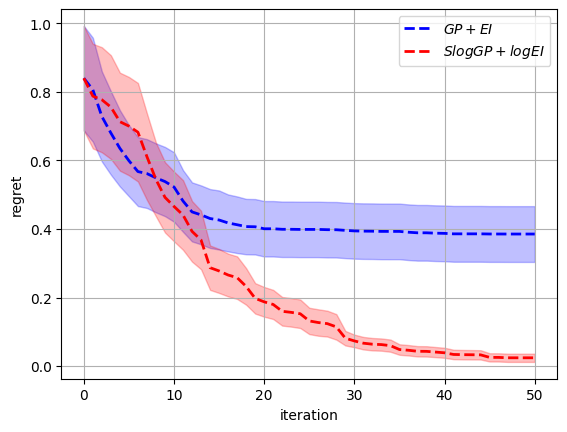

In [105]:
log_RegretMean_plot(GP_res,fstar=0.,label='$GP+EI$',color='blue',linestyle='dashed',error_bound=True)
log_RegretMean_plot(SlogGP_res,fstar=0.,label='$SlogGP+logEI$',color='red',linestyle='dashed',error_bound=True)


plt.xlabel('iteration')
plt.ylabel('regret')
#plt.yscale("log") 
plt.grid()

plt.legend()

In [93]:
np.mean(SlogGP_res,0)

array([0.8396231 , 0.78741337, 0.77683708, 0.75544117, 0.71287252,
       0.69994587, 0.68210732, 0.61067638, 0.54416571, 0.4921252 ,
       0.46563722, 0.44067652, 0.39295056, 0.36771482, 0.28698129,
       0.27749691, 0.26565025, 0.25797443, 0.23230199, 0.19755098,
       0.18740546, 0.17975068, 0.15980912, 0.15674793, 0.1525992 ,
       0.13171858, 0.12704844, 0.12385979, 0.1143863 , 0.08135   ,
       0.07341931, 0.06682174, 0.06387577, 0.06274113, 0.05961219,
       0.04830194, 0.0461746 , 0.04320512, 0.04296692, 0.04089187,
       0.03882188, 0.03393315, 0.03335414, 0.03308291, 0.0327812 ,
       0.02541358, 0.02535471, 0.02422106, 0.02422106, 0.02422106,
       0.02422106])